PIPR with STLAB
===============

In addition to the classical rod and cone photoreceptors, the retina also contains [intrinsically photosensetive retinal ganglion cells (ipRGCs)](https://en.wikipedia.org/wiki/Intrinsically_photosensitive_retinal_ganglion_cell). These cells express a photopigment called [melanopsin](https://en.wikipedia.org/wiki/Melanopsin), which is maximally sensetive to short wavelength (blue) light. The ipRGCs project to the suprachiasmatic nucleus and the olivary pretectal nucleus and are involved in 'non-visual' functions, such as circadian photoentrainment and steady-state pupil control. The [post-illumination pupil response (PIPR)](https://iovs.arvojournals.org/article.aspx?articleid=2186454) describes the sustained constriction of the pupil following exposure to short wavelength blue light, and is assumed to be a unique non-invasive signature of melanopsin processing in the human retina. Here we describe a standard protocol for measuring the PIPR with our STLAB-integrating sphere rig.

![](../img/eye_retina.png)


Preparing stimuli
-----------------

As an optimum protocol for exploring melanopsin function, [Park et al. (2011)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3175993/) recommend comparing the pupil responses to high intensity (~400 lx) 1-second pulses of short and long wavelength light presented in darkness following a period of dark adaptation. Our first task is therefore to prepare stimuli that fit this specification. We can start by creating a `CalibrationContext(...)` from our calibrated spectrometer data.

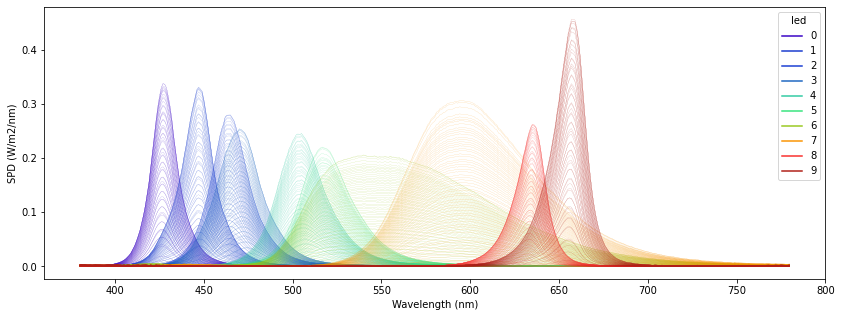

In [1]:
from pyplr.calibrate import CalibrationContext

cc = CalibrationContext(
    '../data/S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()

To confirm which LED is best suited for stimulating melanopsin we can calculate the peak spectral sensitivity for each LED at its maximum intensity setting. 

In [2]:
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    657
dtype: int64

Melanopsin has a peak spectral sensitivity of ~480 nm, which means that LED 3 is our best bet for the melanopic light stimulus. LED 9 is the best choice for the comparison stimulus as it will have the least overlap with the melanopsin spectral sensitivity curve. Having decided which LEDs to use, we can find the intensity settings for the target 400 lux.

In [3]:
blue_led = 3
red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin()
                                      .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led, 
                         match_led_intensity=blue_intensity, 
                         target_led=red_led, 
                         match_type='irrad')[1]

It is helpful to visualise the stimuli along with the spectral sensetivity curve for melanopsin.

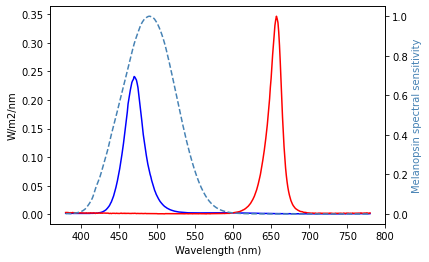

In [4]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(asdf=True, binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')
    
ax2 = ax.twinx()
ax2.plot(sss['Mel'], ls='dashed', c='steelblue')
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

Finally, we can make video files for use with STLAB.

In [5]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity

# Make 1 second pulses
stlab.pulse_protocol(pulse_spec=blue_spec,
                     pulse_duration=1000, 
                     fname='1s_blue',
                     metadata={'color':'blue'})
stlab.pulse_protocol(pulse_spec=red_spec, 
                     pulse_duration=1000, 
                     fname='1s_red',
                     metadata={'color':'red'})

"1s_blue.dsf" saved in the current working directory.
"1s_red.dsf" saved in the current working directory.


Running the protocol
--------------------

Now we are ready to run the protocol. For optimal results, do this after a 20-minute period of dark adatation.

```Python
from time import sleep
import random

from pyplr.pupil import PupilCore
from pyplr.stlab import SpectraTuneLab
from pyplr.protocol import input_subject_id, subject_dir

# Timing function for experimenter feedback
def timer(increment=1, seconds=0, message='Waiting...'):
    print(message)
    while seconds > 0:
        print(f'\t{seconds} seconds left...')
        sleep(increment)
        seconds -= increment

# Specify measurement period and wait between trials (60 s each)
PIPR_MEASUREMENT_PERIOD = 60
INTERTRIAL_INTERVAL = 60 

# List of stims, x3 red and blue, random order of presentation
stims = ['./stimuli/1s_blue.dsf', './stimuli/1s_red.dsf'] * 3
random.shuffle(stims)

# Set up subject and recording
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)

# Connect to Pupil Core
p = PupilCore()

# Connect to stlab
d = SpectraTuneLab(password='****************)')

# Start recording
p.command('R {}'.format(subj_dir))

# Wait a few seconds
timer(seconds=5)

# Trial incrementor variable
trial_num = 0

# Loop over the list of stims
while len(stims) > 0:
    
    # Update trial number
    trial_num += 1
    
    # Pop next stim from the list of stims
    stim = stims.pop(0) 
        
    # Print status update for trial
    print('{}\n{:*^60s}\n{}'.format(
        '*'*60, ' ' + 'Trial number: ' + str(trial_num) + ' ', '*'*60))
    print('Stimulus--> {}\nList of stims--> {}'.format(stim, stims))
    print('{}'.format('-'*60)) 
    
    # Load video file and create trigger with metadata
    vf = d.load_video_file(stim)
    annotation = {**p.new_annotation('LIGHT_ON'), **vf['metadata']}
    annotation['repeat'] = repeat
    annotation['trial_num'] = trial_num
    
    # Check the eye models. If there is a problem, say 'yes' to
    # refit the model, then ask participants to roll their eyes.
    # When a suitable fit is achieved, press 'Enter' to freeze
    # the 3D models. This will stop the 3D models from updating
    # automatically, which can cause issues with the pupil data.
    p.check_3d_model(eyes=[0,1], alert=False)
    sleep(2)
        
    # Notification of stimulus in 5 - 10 s. On mac, should make a beep sound
    print('\a')
    
    # 10 s prestimulus baseline
    timer(seconds=10, message='10 s prestimulus baseline...')
    
    # Set up and start the light_stamper thread 
    lst_future = p.light_stamper(
        threshold=15, annotation=annotation, timeout=6)
    
    # Wait 200 ms
    sleep(.2)
    
    # Play the video file
    d.play_video_file()
    timer(seconds=PIPR_MEASUREMENT_PERIOD, message='Collecting data for PIPR. \
        The participant should be looking straight ahead and hopefully \
        not blinking too much...')
    
    # Notification that data collection period for the current trial has finished
    print('\a')
    print('Finished data collection period for current trial')
    
    # Ask whether to repeat last trial. For example, say yes if their eyes were 
    # closed during stimulus presentation or if they were closed for long periods
    # during the post stimulus data collection period
    repeat = input('Do you want to repeat the last trial [y/n]? ')
    while repeat != 'y' and repeat != 'n':
        print('I do not understand that...')
        repeat = input('Do you want to repeat the last trial [y/n]? ')
    
    # If 'y' to repeat, then put the stimulus back in the list and reshuffle
    if repeat == 'y':
        stims.append(stim)
        random.shuffle(stims)
        
    # Wait between trials, but only if there is actually another trial in 
    # the trial list
    if len(stims) > 0:
        timer(seconds=INTERTRIAL_INTERVAL, message='Wait between trials...')
    
# Finish recording
timer(seconds=5, message='Finishing recording...')  
p.command('r')

```